#### <b>Introduction</b> 
By now we have managed to build a multi-layer NN from scratch which is capable of scoring decent accuracy on the Fashion MNIST dataset. In this phase, we are going to shift our focus to the process of data engineering. We will be creating our own dataset, we will have to carry out some preprocessing on this dataset and will use this to evaluate the network from phase 2 (vectorized).


#### <b>PART 1</b>

This part is essentially the copy pasting of the codes from cells of your phase 2's notebook (Vectorized) to the cells of this notebook. The intent is to replicate phase 2's network and train (using the same OR different hyperparamters) it so that it can be used to evlaute the novel dataset (that will be part 2 of this phase)

In [4]:
# making all the necessary imports here

import numpy as np
import pandas as pd
import time
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from IPython.display import Image
import pydot
from tqdm import tqdm_notebook
import seaborn as sns
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.datasets import make_moons
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
from google.colab import drive
import glob
import cv2

In [5]:
# This function will be used to plot the confusion matrix at the end of this notebook

def plot_confusion_matrix(conf_mat):
    classes = ['T-shirt/top','Trouser/pants','Pullover shirt','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
    df_cm = pd.DataFrame(conf_mat,classes,classes)
    plt.figure(figsize=(15,9))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
    plt.show()

class_labels = ['T-shirt/top','Trouser/pants','Pullover shirt','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

In [6]:
# A random number that will be used for plotting purposes

rollnumber = 24100107

#### __Dataset from Keras Library__

The required library has been imported for you as fashion_mnist. Use it to load the train and test data accordingly.

In [7]:
classes = 10

# Download Fashion MNIST dataset
(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()

# Split the fashion MNIST dataset into train and test sets
# Convert y_train and y_test to categorical binary values 
x_train = x_train/255.0
x_test = x_test/255.0

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
#Reshape train and test images as one-dimensional arrays

x_train = x_train.reshape(60000,784)
x_test = x_test.reshape(10000,784)

trainX = x_train
trainY = y_train


4431872/4422102 [==============================] - 0s 0us/step


#### __NN Implementation__

In [8]:
class NeuralNetwork():
    @staticmethod
    def cross_entropy_loss(y_pred, y_true):
        return (-np.sum(y_true * np.log(y_pred)))/len(y_true)

    @staticmethod
    def accuracy(y_pred, y_true):
        correct_predictions = 0
        total = len(y_pred)
        for i in range(total):
          if y_pred[i] == y_true[i]:
            correct_predictions += 1
        accuracy = (correct_predictions/total)* 100
        return accuracy

    @staticmethod
    def softmax(x):
        denom = np.sum(np.exp(x))
        softmax_array = np.divide(np.exp(x),denom)
        return softmax_array

    @staticmethod
    def sigmoid(x):
        denom = 1 + np.exp(-x)
        return 1/denom

    def __init__(self, nodes_per_layer):
        '''Creates a Feed-Forward Neural Network.
        The parameters represent the number of nodes in each layer. 
        Look at the inputs to the function, and use 'try and accept'
        to catch errors if number of layers are < 2.
        '''
        
        if len(nodes_per_layer)<4:
          raise Exception ("Sorry, not enough hidden layers")
        self.num_layers = len(nodes_per_layer) # including input and output layers
        self.nodes_per_layer = nodes_per_layer
        self.input_shape = nodes_per_layer[0]
        self.output_shape = nodes_per_layer[-1]

        self.weights_ = []
        self.biases_ = []
        self.__init_weights(nodes_per_layer)

    def __init_weights(self, nodes_per_layer):
        '''Initializes all weights based on standard normal distribution and all biases to 0.'''
        '''Initialize weights for each layer except the input layer, since it does not have weights.'''
        
        for i in range(len(nodes_per_layer)-1):
          temp_weights = np.random.normal(size=(nodes_per_layer[i],nodes_per_layer[i+1]))
          self.weights_.append(temp_weights)
          temp_biases = np.zeros(shape=(nodes_per_layer[i+1]),)
          self.biases_.append(temp_biases)
       
    
    def forward_pass(self, input_data):
        '''Executes the feed forward algorithm.
        "input_data" is the input to the network in row-major form
        Returns "activations", which is a list of all layer outputs (excluding input layer of course)'''
        
        activations = []
        input = input_data[0]

        #hidden_layers
        for i in range(len(self.weights_)-1):
          aggregate = np.dot(input,self.weights_[i]) + self.biases_[i]
          activation = self.sigmoid(aggregate)
          
          activations.append(activation)
          input = activation

        #output layer
        input = activations[-1]
        aggregate = np.dot(input,self.weights_[-1]) + self.biases_[-1]
        activation = self.softmax(aggregate)
        activations.append(activation)
              
        return activations

    def sigmoid_derivative(self, x):
      return x*(1-x)
     
    def backward_pass(self, targets, layer_activations):
        '''Executes the backpropogation algorithm.
        "targets" is the ground truth/labels
        "layer_activations" are the return value of the forward pass step
        Returns "deltas", which is a list containing weight update values for all layers (excluding the input layer of course)'''
        
        deltas = []
        deltas_weights = []
        deltas_biases = []
        #output_layer
        layer_activations = np.array(layer_activations) 
        l_activations = layer_activations.copy()
        l_activations = np.flip(l_activations)

        error_in_output_layer =  l_activations[0] - targets
        d_error_wrt_w_o = np.dot( np.reshape(l_activations[1],(len(l_activations[1]),1)) , error_in_output_layer)
        delta_for_w_o = d_error_wrt_w_o
        delta_for_b_o = np.transpose(error_in_output_layer)

        deltas_weights.append(delta_for_w_o)
        deltas_biases.append(delta_for_b_o)

        #hidden_layer
        error_in_next_layer = error_in_output_layer[0]
        weights = self.weights_.copy()
        weights.reverse()
        
        for i in range(self.num_layers-2): 
          error_in_next_layer = np.reshape(error_in_next_layer, (len(error_in_next_layer),1) )
          error_in_hidden_layer = np.dot( weights[i] , error_in_next_layer ) * self.sigmoid_derivative( np.reshape(l_activations[i+1],(len(l_activations[i+1]),1)) )

          if i == (self.num_layers-3): #as we dont have input for first hidden layer
            delta_for_w_h = error_in_hidden_layer
            delta_for_b_h = error_in_hidden_layer
            deltas_weights.append(delta_for_w_h)
            deltas_biases.append(delta_for_b_h)
            break
          
          delta_for_w_h = np.dot( np.reshape(l_activations[i+2],(len(l_activations[i+2]),1)) , np.transpose(error_in_hidden_layer))
          delta_for_b_h = error_in_hidden_layer

          deltas_weights.append(delta_for_w_h)
          deltas_biases.append(delta_for_b_h)
       
          error_in_next_layer = error_in_hidden_layer
        
        
        deltas.append(deltas_weights)
        deltas.append(deltas_biases)
        return deltas
    
    def weight_update(self, deltas, layer_inputs, lr):
        '''Executes the gradient descent algorithm.
        "deltas" is return value of the backward pass step
        "layer_inputs" is a list containing the inputs for all layers (including the input layer)
        "lr" is the learning rate'''
        
        delta_weights = deltas[0] # [wo,wh3,wh2,wh1]
        delta_biases = deltas[1] # [b0,bh3,bh2,bh1]
        
        delta_weights[-1] = np.transpose( np.dot( delta_weights[-1] , layer_inputs[0]) )
        
        delta_weights.reverse()
        delta_biases.reverse()

        for i in range(len(delta_biases)):
          
          delta_biases[i] = np.transpose(delta_biases[i])[0]

        
        for w in range(len(self.weights_)):
          self.weights_[w] = self.weights_[w] - ( lr*delta_weights[w] )
          self.biases_[w] = self.biases_[w] - ( lr*delta_biases[w] )
    
    def fit(self, Xs, Ys, epochs, lr=1e-3):
            history = []
            for epoch in tqdm_notebook(range(epochs)):
                num_samples = Xs.shape[0]
                for i in range(num_samples):

                    sample_input = Xs[i,:].reshape((1,self.input_shape))
                    sample_target = Ys[i,:].reshape((1,self.output_shape))
                    
                    activations = self.forward_pass(sample_input)   # Call forward_pass function 
                    deltas = self.backward_pass(sample_target, activations)    # Call backward_pass function 
                    layer_inputs = [sample_input] + activations[:-1]
                    
                    # Call weight_update function 
                    self.weight_update(deltas, layer_inputs, lr)
                
                preds = self.predict(Xs)   # Call predict function 

                current_loss = self.cross_entropy_loss(preds, Ys)
                
                if  epoch==epochs-1:
                  confusion_mat=confusion_matrix(Ys.argmax(axis=1), preds.argmax(axis=1),labels=np.arange(10))  
                  plot_confusion_matrix(confusion_mat)
                  report = classification_report(Ys, np_utils.to_categorical(preds.argmax(axis=1),num_classes=classes), target_names=class_labels)
                  print(report)
                history.append(current_loss)
            return history
    
    def predict(self, Xs):
        '''Returns the model predictions (output of the last layer) for the given "Xs".'''
        predictions = []
        num_samples = Xs.shape[0]
        for i in range(num_samples):
            sample = Xs[i,:].reshape((1,self.input_shape))
            sample_prediction = self.forward_pass(sample)[-1]
            predictions.append(sample_prediction.reshape((self.output_shape,)))
        return np.array(predictions)
    
    def evaluate(self, Xs, Ys):
        '''Returns appropriate metrics for the task, calculated on the dataset passed to this method.'''
        pred = self.predict(Xs)
        return self.cross_entropy_loss(pred, Ys), self.accuracy(pred.argmax(axis=1), Ys.argmax(axis=1))
    
    def plot_model(self, filename):
        '''Provide the "filename" as a string including file extension. Creates an image showing the model as a graph.'''
        graph = pydot.Dot(graph_type='digraph')
        graph.set_rankdir('LR')
        graph.set_node_defaults(shape='circle', fontsize=0)
        nodes_per_layer = [self.input_shape, self.hidden_shape, self.output_shape]
        for i in range(self.num_layers-1):
            for n1 in range(nodes_per_layer[i]):
                for n2 in range(nodes_per_layer[i+1]):
                    edge = pydot.Edge(f'l{i}n{n1}', f'l{i+1}n{n2}')
                    graph.add_edge(edge)
        graph.write_png(filename)

In [9]:
# These are what we call the hyperparameters
EPOCH = 25           # must be an int
LEARNING_RATE = 0.001
nodes_per_layer = [784, 60, 50, 40, 30, 10]  #int values for nodes of each layer. # of hidden layers >= 2. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:173: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


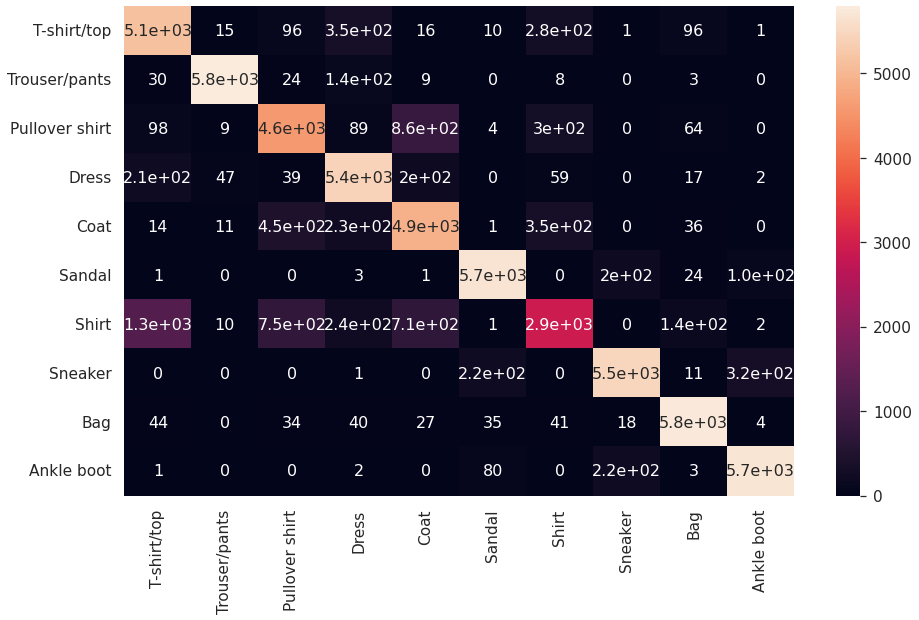

                precision    recall  f1-score   support

   T-shirt/top       0.76      0.86      0.80      6000
 Trouser/pants       0.98      0.97      0.97      6000
Pullover shirt       0.77      0.76      0.76      6000
         Dress       0.83      0.90      0.87      6000
          Coat       0.73      0.82      0.77      6000
        Sandal       0.94      0.94      0.94      6000
         Shirt       0.74      0.48      0.58      6000
       Sneaker       0.93      0.91      0.92      6000
           Bag       0.94      0.96      0.95      6000
    Ankle boot       0.93      0.95      0.94      6000

     micro avg       0.86      0.86      0.86     60000
     macro avg       0.85      0.86      0.85     60000
  weighted avg       0.85      0.86      0.85     60000
   samples avg       0.86      0.86      0.86     60000

Runtime of the algorithm is  2395.245  seconds
(0.47676387313287294, 82.89999999999999)


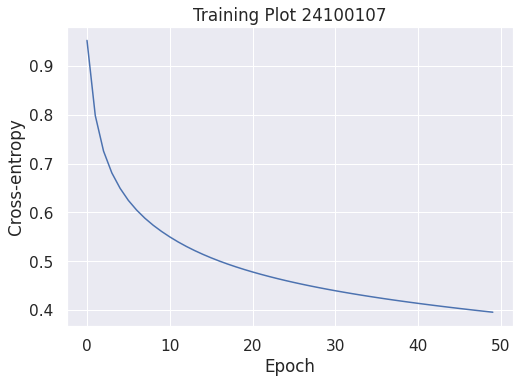

In [10]:
start = time.time()

# Instantiate the neural network with the number of nodes you choose per layer, right now it is done for three layers only.
nn = NeuralNetwork(nodes_per_layer=nodes_per_layer)
history = nn.fit(trainX, trainY, epochs=EPOCH, lr=LEARNING_RATE)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='Cross-entropy', title='Training Plot {}'.format(rollnumber));
end = time.time()

print("Runtime of the algorithm is ", round((end - start),3)," seconds")

# print accuracy on test set here
print(nn.evaluate(x_test,y_test))

#### <b>PART 2</b>

Now that the NN model has been replicated and trained, we move on to the actual part of this phase i.e. making our own dataset. The instruction for creating your own dataset are as follows:

- Each group has to create a dataset of 50 images (preferred way to go about this is that each member takes 10 pictures for the dataset)
- Make sure that all the classes/categories that are there in the Fashion MNIST dataset are covered in these 50 pictures. 
- Make sure that that there is no class imbalance in your dataset. Class imbalance is when one or more classes have more images/data than others
- Once done with taking the pictures, add them into folders where the name of the folder will be the label of that image (for reference, you can have a look at how phase 1's dataset was organized as you essentially have to replicate that directory tree with the only difference is that there will only be `test` folder as this dataset is only being used for evaluation purposes)
- Zip the dataset and upload it on your Google Drive. You will have to mount your drive and import your dataset in the same way as it was done in phase 1

Once done, you will be reading the your dataset in the notebook and storing it in variables (please make sure that you are not overwriting any variable from Part 1). This will be followed by preprocessing that you will have to do on the images an finally, you will be able to evalute your model 

<b>Note: It is important that you know the classes/categories, shape and other information regarding the Fashion MNIST dataset on which your model is trained because for your own dataset, you will have to generate the data/images such that they are inline with those same properties and classes otherwise your network will make a lot of misclassifications. You can read up on the Fashion MNIST dataset [here](https://www.kaggle.com/zalando-research/fashionmnist): to familiarize yourself with the dataset</b>

In [11]:
# %rm -rf </content/data/test/>

# Mounting Google Drive here
drive.mount('/drive')

# Edit this address so that it points to the dataset's zipped file on your Google Drive
!unzip -o -q "/drive/MyDrive/myDataSet.zip" -d "/content/data/"

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [12]:
classes = 10  # do not change this
my_X_test = None   # you must store the test images of your dataset in this varaible
my_y_test = None   # you must store the test images' labels of your dataset in this varaible

from google.colab.patches import cv2_imshow

'''Please note that you will have to extarct and one-hot encode the labels of the images for my_y_test'''
my_X_test = []
my_y_test = []

class_labels = ['T-shirt','Trouser','Pullover shirt','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

for folder in glob.glob('/content/data/test/*/'):
  label = folder[19:-1]
  # print(label)
  string = folder +'/*.png'
  for img in glob.glob(string):
    
    n= cv2.imread(img,cv2.IMREAD_GRAYSCALE)
    # cv2_imshow(n)
    
    my_X_test.append(n)
    my_y_test.append(class_labels.index(label))

my_y_test = np_utils.to_categorical(my_y_test)

print("Number of images in the dataset: ", len(my_X_test))    # You can change len(X_test) based on your implementation such that total number of test samples is printed

Number of images in the dataset:  50


Now you have to do the preprocessing of the images such that they are inline with the image properties of the images of Fashion MNIST dataset. This is the core task of this phase and completely dependent on your own research on preprocessing of data

<b>HINT: Data Normalization is one of the ways the data is preprocessed</b>

In [13]:
'''Do data preprocessing here. Whatever you do here, please make sure that at the very end your images are in my_X_test and labels are in my_y_test'''
# We have already converted the rgb images into grayscale when reading them using cv2
# Our pictures were already 28x28 pixels when we uploaded them to the drive.

# Turning the white background black
for x in my_X_test:
  white_pixels = np.where(x[:] > 230)
  x[white_pixels] = 0
  
my_X_test = np.array(my_X_test)
my_X_test = my_X_test/255.0
my_X_test = my_X_test.reshape(len(my_X_test),784)

In [14]:
print(nn.evaluate(my_X_test,my_y_test))

(2.431931898845253, 50.0)
